In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import warnings
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import f_regression, SelectFwe
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor
from xgboost import plot_importance

In [94]:
# ingore warning
warnings.filterwarnings("ignore")

# 1. Data Preprocessing

In [95]:
def CheckWeekend(year, month, day):
    convertDate = datetime.date(year, month, day)
    convertDateResult = convertDate.weekday()
    if convertDateResult <= 4:
        return False
    return True

# import dataset
df = pd.read_excel("Data_Train.xlsx", engine='openpyxl')

# drop null value
df.dropna(inplace=True)

# drop duplicates
df.drop_duplicates(keep='first', inplace=True)

# convert Dep_Time and Arrival_Time into hour and minute
# Dep_Time
df["Dep_hour"] = pd.to_datetime(df["Dep_Time"]).dt.hour
df["Dep_minute"] = pd.to_datetime(df["Dep_Time"]).dt.minute
df = df.drop(columns="Dep_Time")

# Arrival_Time
df["Arr_hour"] = pd.to_datetime(df["Arrival_Time"]).dt.hour
df["Arr_minute"] = pd.to_datetime(df["Arrival_Time"]).dt.minute
df = df.drop(columns="Arrival_Time")

# convert Date_of_Journey into timestamp
df["Date_of_Journey_Year"] = pd.to_datetime(
    df["Date_of_Journey"], format="%d/%m/%Y").dt.year
# ps. I don't think "year" is mandatory
df["Date_of_Journey_Month"] = pd.to_datetime(
    df["Date_of_Journey"], format="%d/%m/%Y").dt.month
df["Date_of_Journey_Day"] = pd.to_datetime(
    df["Date_of_Journey"], format="%d/%m/%Y").dt.day
df = df.drop(columns="Date_of_Journey")


# convert Duration into minute
df['Duration'] = df['Duration']\
    .str.replace("h", '*60')\
    .str.replace(' ', '+')\
    .str.replace('m', '*1')\
    .apply(eval)

# drop Additional_Info 
df.drop(['Additional_Info'], axis=1, inplace=True)

# drop Route
df.drop(['Route'], axis=1, inplace=True) 

# Encode categorical attributes
# Select categorical data
df_categorical = df[['Airline', 'Source', 'Destination']]
df.drop(['Airline', 'Source', 'Destination'], axis=1, inplace=True)


# Encode
df_categorical = pd.get_dummies(df_categorical, drop_first=True, dtype=int)
df['Total_Stops'] = df['Total_Stops'].map({"non-stop":0, "1 stop": 1, "2 stops": 2, "3 stops":3, "4 stops": 4})

# Concat categorical and numerical data
preprocessed = pd.concat([df, df_categorical], axis=1)
target = df['Price']

# Drop 'Price' because price is the target variable
preprocessed.drop(['Price'], axis=1, inplace=True)

## Feature Engineering - check if date is weekday or weekend
preprocessed["IsWeekend"] = preprocessed.apply(lambda x: 1 if CheckWeekend(x["Date_of_Journey_Year"], x["Date_of_Journey_Month"], x["Date_of_Journey_Day"]) else 0, axis=1)


# 2. Model Training & Performance

In [96]:
# Train_Test_Split
data_train, data_test, target_train, target_test = train_test_split(
    preprocessed, target,test_size=0.3, random_state=42)

In [97]:
data_train.head()

,Duration,Total_Stops,Dep_hour,Dep_minute,Arr_hour,Arr_minute,Date_of_Journey_Year,Date_of_Journey_Month,Date_of_Journey_Day,Airline_Air India,...,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,IsWeekend
5050,1830,3,16,45,23,15,2019,4,1,1,...,0,0,1,0,0,0,0,0,0,0
4879,480,1,13,0,21,0,2019,6,1,0,...,0,1,0,0,1,0,0,0,0,1
208,570,1,14,5,23,35,2019,5,21,0,...,0,0,1,0,0,0,0,0,0,0
8561,930,1,10,0,1,30,2019,6,9,0,...,0,1,0,0,1,0,0,0,0,1
7265,165,0,22,10,0,55,2019,3,21,0,...,0,0,1,0,0,0,0,0,0,0


In [98]:
data_test.head()

,Duration,Total_Stops,Dep_hour,Dep_minute,Arr_hour,Arr_minute,Date_of_Journey_Year,Date_of_Journey_Month,Date_of_Journey_Day,Airline_Air India,...,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,IsWeekend
2150,1455,1,8,0,8,15,2019,3,6,0,...,0,0,0,0,0,0,0,0,1,0
3784,140,0,22,20,0,40,2019,6,6,0,...,0,0,1,0,0,0,0,0,0,0
714,170,0,5,30,8,20,2019,3,18,0,...,0,0,1,0,0,0,0,0,0,0
7558,90,0,15,50,17,20,2019,3,24,0,...,0,0,0,1,0,0,1,0,0,1
7413,170,0,9,30,12,20,2019,4,27,0,...,0,0,0,0,0,1,0,0,0,1


In [99]:
# normalize 'duration'

# Copy data
data_train_normalize = data_train.copy()
data_test_normalize = data_test.copy()

# create the normaliser
scaler = preprocessing.StandardScaler()
data_train_normalize[['Duration']] = scaler.fit_transform(data_train_normalize[['Duration']])
data_test_normalize[['Duration']] = scaler.transform(data_test_normalize[['Duration']])

data_train_normalize.head()

,Duration,Total_Stops,Dep_hour,Dep_minute,Arr_hour,Arr_minute,Date_of_Journey_Year,Date_of_Journey_Month,Date_of_Journey_Day,Airline_Air India,...,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,IsWeekend
5050,2.408958,3,16,45,23,15,2019,4,1,1,...,0,0,1,0,0,0,0,0,0,0
4879,-0.303560,1,13,0,21,0,2019,6,1,0,...,0,1,0,0,1,0,0,0,0,1
208,-0.122725,1,14,5,23,35,2019,5,21,0,...,0,0,1,0,0,0,0,0,0,0
8561,0.600613,1,10,0,1,30,2019,6,9,0,...,0,1,0,0,1,0,0,0,0,1
7265,-0.936481,0,22,10,0,55,2019,3,21,0,...,0,0,1,0,0,0,0,0,0,0


In [100]:
# score function
def cal_score(model, normalize=False):
    if normalize:
        X_test = data_test_normalize
    else:
        X_test = data_test
        
    predictions = model.predict(X_test)
    
    # R-Squared
    R2_score = r2_score(target_test, predictions)
    R2_scores.append(R2_score)
    print('R-squared: ' + str(R2_score))

    # RMSE
    RMSE_score = root_mean_squared_error(target_test, predictions)
    RMSE_scores.append(RMSE_score)
    print("RMSE : " + str(RMSE_score))

In [101]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [102]:
def reverse_scores():
    R2_scores.pop()
    RMSE_scores.pop()

In [103]:
R2_scores = []
RMSE_scores = []

### 0. Average Price as Prediction (Baseline)

In [104]:
# create prediction result
average_price = target_train.mean()
y_pred_average_price = np.empty(len(target_test))
y_pred_average_price.fill(average_price)
y_pred_average_price

array([9053.2321453, 9053.2321453, 9053.2321453, ..., 9053.2321453,
       9053.2321453, 9053.2321453], shape=(3139,))

In [105]:
# performance

# R-Squared
R2_score = r2_score(target_test, y_pred_average_price)
R2_scores.append(R2_score)
print('R-squared: ' + str(R2_score))

# RMSE
RMSE_score = root_mean_squared_error(target_test, y_pred_average_price)
RMSE_scores.append(RMSE_score)
print("RMSE : " + str(RMSE_score))

R-squared: -0.00037395873469936447
RMSE : 4558.1088719559


### 1. Linear Regression

#### 1-1. Model Training

In [106]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(data_train, target_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


#### 1-2. Performance

In [107]:
cal_score(linear_regression_model)

R-squared: 0.611521042358869
RMSE : 2840.450695455


#### 1-3. Analysis

In [108]:
# Calculate the number of samples and predictors
n = len(target_test)
p = data_test.shape[1]

# Calculate adjusted R-squared
adjusted_r2 = 1 - (1 - R2_scores[1]) * (n - 1) / (n - p - 1)

# Print the adjusted R-squared score
print("Adjusted R-Squared (Adjusted R^2):", adjusted_r2)

Adjusted R-Squared (Adjusted R^2): 0.607771245470441


In [109]:
# Intercept: The base price when all features are zero
# (e.g., predicted price with no other factors considered)
print("Intercept:", linear_regression_model.intercept_)

Intercept: 6991.540366167872


In [110]:
# Display coefficients with feature names
coef_df = pd.DataFrame({
    'Feature': data_train.columns,
    'Coefficient': linear_regression_model.coef_
})
print(coef_df.sort_values('Coefficient', ascending=False))

                                      Feature   Coefficient
13               Airline_Jet Airways Business  4.662124e+04
12                        Airline_Jet Airways  4.458565e+03
15  Airline_Multiple carriers Premium economy  4.064985e+03
14                  Airline_Multiple carriers  3.836520e+03
19            Airline_Vistara Premium economy  2.848635e+03
1                                 Total_Stops  2.833769e+03
18                            Airline_Vistara  2.110164e+03
28                      Destination_New Delhi  1.732280e+03
9                           Airline_Air India  1.604312e+03
11                             Airline_IndiGo  2.604894e+02
29                                  IsWeekend  2.125027e+02
20                             Source_Chennai  6.171960e+01
27                        Destination_Kolkata  6.171960e+01
2                                    Dep_hour  2.309017e+01
5                                  Arr_minute  3.118825e+00
0                                    Dur

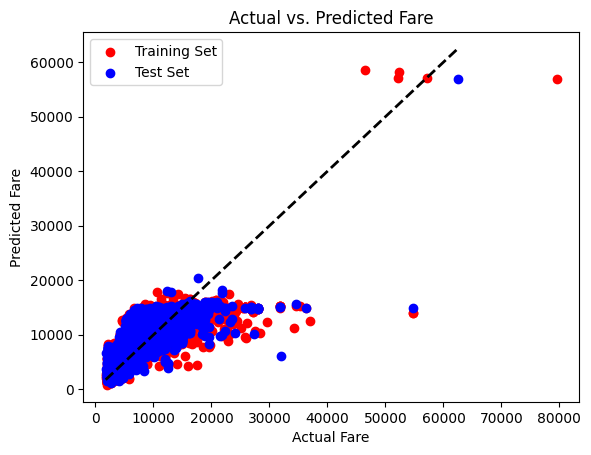

In [111]:
# Plotting the linear regression
plt.scatter(target_train, linear_regression_model.predict(data_train), color='red', label='Training Set')
plt.scatter(target_test, linear_regression_model.predict(data_test), color='blue', label='Test Set')
plt.plot([target_test.min(), target_test.max()], [target_test.min(), target_test.max()], 'k--', lw=2)
plt.xlabel('Actual Fare')
plt.ylabel('Predicted Fare')
plt.title('Actual vs. Predicted Fare')
plt.legend()
plt.show()

### 2. Polynomial Regression

#### 2-1. Model Training

In [112]:
# 3-step pipeline: polynomial features → statistical filter → linear regression
# Degree=2 creates interaction terms (e.g., Duration², Duration×Dep_hour)
# SelectFwe keeps only statistically significant features (p < 0.05)
transformer = PolynomialFeatures(degree=2, include_bias=False)
best = SelectFwe(f_regression, alpha=0.05)
estimator = LinearRegression()
poly_regression_model = Pipeline([
    ('transformer', transformer), 
    ('feature_selection', best), 
    ('estimator', estimator)
])
poly_regression_model.fit(data_train_normalize, target_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('transformer', ...), ('feature_selection', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"degree degree: int or tuple (min_degree, max_degree), default=2If a single int is given, it specifies the maximal degree of thepolynomial features. If a tuple `(min_degree, max_degree)` is passed,then `min_degree` is the minimum and `max_degree` is the maximumpolynomial degree of the generated features. Note that `min_degree=0`and `min_degree=1` are equivalent as outputting the degree zero term isdetermined by `include_bias`.",2
,"interaction_only interaction_only: bool, default=FalseIf `True`, only interaction features are produced: features that areproducts of at most `degree` *distinct* input features, i.e. terms withpower of 2 or higher of the same input feature are excluded:- included: `x[0]`, `x[1]`, `x[0] * x[1]`, etc.- excluded: `x[0] ** 2`, `x[0] ** 2 * x[1]`, etc.",False
,"include_bias include_bias: bool, default=TrueIf `True` (default), then include a bias column, the feature in whichall polynomial powers are zero (i.e. a column of ones - acts as anintercept term in a linear model).",False
,"order order: {'C', 'F'}, default='C'Order of output array in the dense case. `'F'` order is faster tocompute, but may slow down subsequent estimators... versionadded:: 0.21",'C'
,"score_func score_func: callable, default=f_classifFunction taking two arrays X and y, and returning a pair of arrays(scores, pvalues).Default is f_classif (see below ""See Also""). The default function onlyworks with classification tasks.",<function f_r...t 0x11aaafb60>
,"alpha alpha: float, default=5e-2The highest uncorrected p-value for features to keep.",0.05
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True


#### 2-2. Performance

In [113]:
cal_score(poly_regression_model, normalize=True)

R-squared: 0.6892126705902644
RMSE : 2540.5933536190155


#### 2-3. Analysis

In [114]:
# Create polynomial features and test their statistical significance
transformer = PolynomialFeatures(degree=2, include_bias=False)

# Run F-test: measures how much each feature helps predict price
# F-value: higher = more predictive
# p-value: lower = more statistically significant (< 0.05 is good)
f, pval = f_regression(transformer.fit_transform(data_train_normalize), target_train)

# Create results table with F and p-values for each feature
stat = pd.DataFrame({
    'feature': transformer.get_feature_names_out(data_train_normalize.columns),
    'F value': f,
    'p value': pval
})
stat['p value'] = round(stat['p value'], 2)

display(stat)

,feature,F value,p value
0,Duration,2418.001683,0.00
1,Total_Stops,4080.632555,0.00
2,Dep_hour,1.997667,0.16
3,Dep_minute,4.815703,0.03
4,Arr_hour,7.350185,0.01
...,...,...,...
490,Destination_Kolkata Destination_New Delhi,0.000000,1.00
491,Destination_Kolkata IsWeekend,50.370959,0.00
492,Destination_New Delhi^2,302.040290,0.00
493,Destination_New Delhi IsWeekend,13.395025,0.00


In [115]:
# get the selected features
selected_features = poly_regression_model.named_steps['feature_selection'].get_support()

# print the selected variables
for i, f in enumerate(poly_regression_model.named_steps['transformer'].get_feature_names_out(data_train_normalize.columns)):
    if selected_features[i]:
        print(f)

Duration
Total_Stops
Arr_minute
Date_of_Journey_Month
Date_of_Journey_Day
Airline_Air India
Airline_GoAir
Airline_IndiGo
Airline_Jet Airways
Airline_Jet Airways Business
Airline_Multiple carriers
Airline_SpiceJet
Airline_Vistara
Source_Chennai
Source_Delhi
Source_Mumbai
Destination_Cochin
Destination_Delhi
Destination_Hyderabad
Destination_Kolkata
Destination_New Delhi
Duration^2
Duration Total_Stops
Duration Dep_hour
Duration Dep_minute
Duration Arr_hour
Duration Arr_minute
Duration Date_of_Journey_Year
Duration Date_of_Journey_Month
Duration Date_of_Journey_Day
Duration Airline_Air India
Duration Airline_GoAir
Duration Airline_IndiGo
Duration Airline_Jet Airways
Duration Airline_Jet Airways Business
Duration Airline_SpiceJet
Duration Airline_Vistara
Duration Source_Chennai
Duration Source_Delhi
Duration Source_Kolkata
Duration Source_Mumbai
Duration Destination_Cochin
Duration Destination_Delhi
Duration Destination_Hyderabad
Duration Destination_Kolkata
Duration Destination_New Delhi

### 3. Regression Tree

#### 3-1. Model Training without Tuning

In [116]:
# Initializing the Decision Tree Regression model
rg_tree_basic = DecisionTreeRegressor(random_state = 42)

# Fitting the Decision Tree Regression model to the data
rg_tree_basic.fit(data_train, target_train)

,"criterion criterion: {""squared_error"", ""friedman_mse"", ""absolute_error"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in the half mean Poisson deviance to find splits... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 0.24 Poisson deviance criterion.",'squared_error'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.For an example of how ``max_depth`` influences the model, see:ref:`sphx_glr_auto_examples_tree_plot_tree_regression.py`.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_l

#### 3-2. Model Training with hyperparameter tuning

In [117]:
# specify the parameter grid
parameter_grid = {'max_features': [1.0, 'sqrt'],
          'max_depth':[int(x) for x in np.linspace(start = 1, stop = 20, num = 20)],
          'min_samples_leaf':[int(x) for x in np.linspace(start = 1, stop = 20, num = 20)],
          'min_samples_split':[int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
         }

regression_tree_model = DecisionTreeRegressor(random_state = 42)
regression_tree_rs = RandomizedSearchCV(random_state = 42, estimator=regression_tree_model, param_distributions=parameter_grid, scoring='neg_root_mean_squared_error', cv=5, n_iter=10)
regression_tree_rs.fit(data_train, target_train)
print('Best parameters: ',regression_tree_rs.best_params_)

Best parameters:  {'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 1.0, 'max_depth': 15}


#### 3-3. Performance

In [118]:
print("Model without hyperparameter tuning")
print("")

#use cross-validation to estimate model performance
cross_regression_tree = cross_val_score(rg_tree_basic, data_train, target_train, cv=10, scoring='neg_root_mean_squared_error')
print('Average Cross-Validation RMSE score: ', -cross_regression_tree.mean())

# Predicting the target values of the test set
y_pred = rg_tree_basic.predict(data_test)


#Evaluate the model on the testing set
#r_squared
r2_regression_tree = r2_score(target_test, y_pred)
print('R-Squared:', r2_regression_tree)

#RMSE
root_mean_squared_error_regression_tree = root_mean_squared_error(target_test, y_pred)
print('RMSE:', root_mean_squared_error_regression_tree)

print("---------------------------------------")

print("Model with hyperparameter tuning")
print("")

cross_regression_tree = cross_val_score(regression_tree_rs, data_train, target_train, cv=10, scoring='neg_root_mean_squared_error')
print('Average Cross-Validation RMSE score: ', -cross_regression_tree.mean())
cal_score(regression_tree_rs)

Model without hyperparameter tuning

Average Cross-Validation RMSE score:  2593.421888928896
R-Squared: 0.692064198467379
RMSE: 2528.9113023996815
---------------------------------------
Model with hyperparameter tuning

Average Cross-Validation RMSE score:  2486.630094928897
R-squared: 0.7308717527849882
RMSE : 2364.194195710645


### 4. Random Forest

#### 4-1. Training without Tuning

In [119]:
rf_model_basic = RandomForestRegressor()
rf_model_basic.fit(data_train, target_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

#### 4-2. Training with hyperparameter tuning

In [120]:
# specify the parameter grid
parameter_grid = {
    'max_depth': [int(x) for x in np.linspace(10, 100, 10)],
    'max_features': [1.0, 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [int(x) for x in np.linspace(50, 500, 10)]
}

In [121]:
# specify the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

rf_model = RandomForestRegressor()
rf_model_rs = RandomizedSearchCV(rf_model, parameter_grid, scoring='neg_root_mean_squared_error', cv=stratified_10_fold_cv, error_score='raise')

rf_model_rs.fit(data_train, target_train)

# print the results of all hyper-parameter combinations
results = pd.DataFrame(rf_model_rs.cv_results_)
display(results)

# print the best parameter setting
print("Best score is {} with params {}".format(-rf_model_rs.best_score_, rf_model_rs.best_params_))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,5.773866,0.075100,0.063723,0.001686,500,5,1,1.0,80,"{'n_estimators': 500, 'min_samples_split': 5, ...",...,-2492.134358,-1957.707624,-1881.831009,-1950.505134,-2412.546647,-1769.569599,-1833.072018,-1996.944356,251.569650,2
1,4.715861,0.083978,0.049684,0.001441,450,10,1,1.0,70,"{'n_estimators': 450, 'min_samples_split': 10,...",...,-2478.859216,-1931.364994,-1713.202726,-1944.708651,-2292.734287,-1761.234067,-1817.066883,-1954.579833,251.619797,1
2,0.300645,0.003303,0.012612,0.000424,100,5,2,sqrt,80,"{'n_estimators': 100, 'min_samples_split': 5, ...",...,-2679.831375,-2132.934240,-1813.406155,-2221.328942,-2481.281977,-1860.207687,-1920.403297,-2109.516408,281.766187,7
3,2.803664,0.044416,0.032385,0.000453,250,2,2,1.0,80,"{'n_estimators': 250, 'min_samples_split': 2, ...",...,-2763.062675,-2030.307438,-1843.638557,-2154.516321,-2371.032475,-1768.577318,-1789.160691,-2039.091373,312.257151,5
4,0.997016,0.010634,0.041109,0.000933,250,2,1,sqrt,80,"{'n_estimators': 250, 'min_samples_split': 2, ...",...,-2569.468314,-2148.935001,-1865.350211,-1992.471023,-2389.675888,-1865.847928,-1911.668514,-2078.899222,232.605504,6
5,1.376443,0.007389,0.054527,0.000734,500,10,1,sqrt,40,"{'n_estimators': 500, 'min_samples_split': 10,...",...,-2584.863053,-2122.928427,-1759.225258,-1935.803067,-2342.892774,-1839.450633,-1845.314148,-2032.663122,259.262628,4
6,1.023203,0.003934,0.040732,0.000247,500,5,4,sqrt,10,"{'n_estimators': 500, 'min_samples_split': 5, ...",...,-3071.805913,-2364.563269,-1998.026476,-2803.560340,-2947.578398,-2124.527898,-2307.831691,-2432.042866,367.527627,10
7,1.065430,0.008351,0.041644,0.000576,500,2,2,sqrt,10,"{'n_estimators': 500, 'min_samples_split': 2, ...",...,-2805.955239,-2348.755879,-1961.323289,-2404.426429,-2634.481587,-2092.296233,-2138.531467,-2300.167877,266.546088,9
8,0.392195,0.011218,0.015984,0.000326,150,2,4,sqrt,30,"{'n_estimators': 150, 'min_samples_split': 2, ...",...,-2963.109206,-2207.014254,-1846.506279,-2665.835168,-2797.757497,-1955.738079,-2172.994146,-2281.635165,378.236893,8
9,0.804380,0.008902,0.008897,0.000189,100,5,1,1.0,10,"{'n_estimators': 100, 'min_samples_split': 5, ...",...,-2487.879061,-2001.324523,-1839.804917,-1981.545315,-2438.665757,-1858.067113,-1847.104460,-2025.924396,250.589865,3


Best score is 1954.5798331434885 with params {'n_estimators': 450, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 1.0, 'max_depth': 70}


#### 4-3. Performance

In [122]:
print("Model without hyperparameter tuning")
print("")

# Predicting the target values of the test set
y_pred = rf_model_basic.predict(data_test)


#Evaluate the model on the testing set
#r_squared
r2_rf = r2_score(target_test, y_pred)
print('R-Squared:', r2_rf)

#RMSE
root_mean_squared_error_rf = root_mean_squared_error(target_test, y_pred)
print('RMSE:', root_mean_squared_error_rf)

print("---------------------------------------")

print("Model with hyperparameter tuning")
print("")

cal_score(rf_model_rs)

Model without hyperparameter tuning

R-Squared: 0.8150432887573689
RMSE: 1959.9209381393914
---------------------------------------
Model with hyperparameter tuning

R-squared: 0.8330834223004611
RMSE : 1861.8866637326944


#### 4-4. Analysis

In [125]:
# impurity-based importances
importances = rf_model_rs.best_estimator_.feature_importances_
for i, f in zip(list(data_train.columns), importances):
    print(f"{i}: {round(f*100, 2)}")

Duration: 47.23
Total_Stops: 2.96
Dep_hour: 2.05
Dep_minute: 2.02
Arr_hour: 3.17
Arr_minute: 1.8
Date_of_Journey_Year: 0.0
Date_of_Journey_Month: 5.79
Date_of_Journey_Day: 11.83
Airline_Air India: 0.42
Airline_GoAir: 0.19
Airline_IndiGo: 0.71
Airline_Jet Airways: 6.43
Airline_Jet Airways Business: 7.96
Airline_Multiple carriers: 2.07
Airline_Multiple carriers Premium economy: 0.09
Airline_SpiceJet: 0.27
Airline_Trujet: 0.0
Airline_Vistara: 0.27
Airline_Vistara Premium economy: 0.0
Source_Chennai: 0.07
Source_Delhi: 0.24
Source_Kolkata: 0.39
Source_Mumbai: 0.46
Destination_Cochin: 0.25
Destination_Delhi: 0.04
Destination_Hyderabad: 0.41
Destination_Kolkata: 0.06
Destination_New Delhi: 2.22
IsWeekend: 0.59


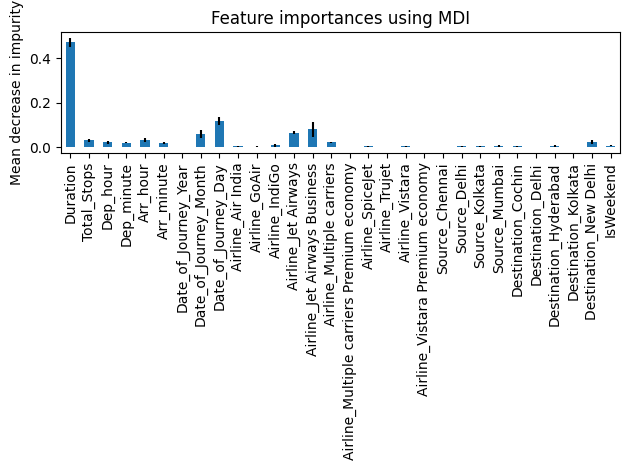

In [126]:
forest_importances = pd.Series(importances, index=list(data_train.columns))

fig, ax = plt.subplots()
std = np.std([tree.feature_importances_ for tree in rf_model_rs.best_estimator_], axis=0)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### 5. XGBoost

#### 5-1. Training without Tuning

In [127]:
xgboost_model_basic = XGBRegressor()
xgboost_model_basic.fit(data_train,target_train)

,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,None
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_met

#### 5-2. Training with hyperparameter tuning

In [128]:
# specify the parameter grid
n_estimators_range = [100, 300, 500]
leaning_rate_range = [0.01, 0.05, 0.1]
max_depth_range = [3, 5, 7, 9, 12]
reg_lambda_range = [0.001, 0.1, 1.0, 10.0, 100.0]

parameter_grid = {"n_estimators": n_estimators_range, 
                  "learning_rate": leaning_rate_range,
                  "max_depth": max_depth_range,
                  "reg_lambda": reg_lambda_range}

# Hyperparameter Optimization
xgboost_model = XGBRegressor()
xgboost_rs = RandomizedSearchCV(xgboost_model, parameter_grid, scoring="neg_root_mean_squared_error", cv=5)
xgboost_rs.fit(data_train,target_train)

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBRegressor(...ree=None, ...)"
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], 'n_estimators': [100, 300, ...], 'reg_lambda': [0.001, 0.1, ...]}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",10
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'neg_root_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies t

#### 5-3. Performance

In [133]:
print("Model without hyperparameter tuning")
print("")

# Predicting the target values of the test set
y_pred = xgboost_model_basic.predict(data_test)

#Evaluate the model on the testing set

#r_squared
r2_rf = r2_score(target_test, y_pred)
print('R-Squared:', r2_rf)

#RMSE
root_mean_squared_error_rf = root_mean_squared_error(target_test, y_pred)
print('RMSE:', root_mean_squared_error_rf)

print("---------------------------------------")

print("Model with hyperparameter tuning")
print("")

y_pred = xgboost_rs.predict(data_test)
cal_score(xgboost_rs)

Model without hyperparameter tuning

R-Squared: 0.8354504108428955
RMSE: 1848.6383056640625
---------------------------------------
Model with hyperparameter tuning

R-squared: 0.8333068490028381
RMSE : 1860.6402587890625


#### 5-4. Analysis

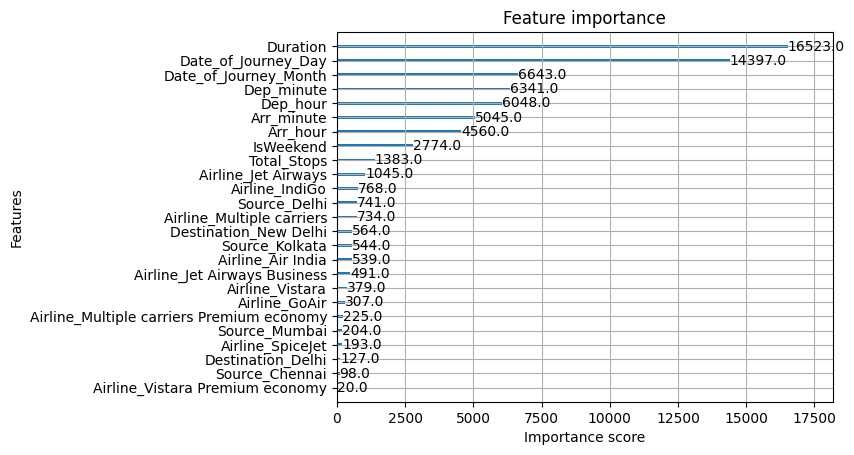

In [130]:
# impurity-based importances
plot_importance(xgboost_rs.best_estimator_)
plt.show()

# 3. Comparison

In [131]:
# print out all of the results
grid_dict = {0: 'Linear Regression', 1: 'Polynomial Regression', 2: 'Regression Tree', 3: 'Random Forest', 4: 'XGBoost'}

print('Average Price(Baseline)')
print('R-squared: {}'.format(R2_scores[0]))
print('RMSE: {}'.format(RMSE_scores[0]))
print('')

for i in range(len(grid_dict)):
    print('Model {}: {}'.format(i+1, grid_dict[i]))
    print('R-squared: {}'.format(R2_scores[i+1]))
    print('RMSE: {}'.format(RMSE_scores[i+1]))
    print('')

Average Price(Baseline)
R-squared: -0.00037395873469936447
RMSE: 4558.1088719559

Model 1: Linear Regression
R-squared: 0.611521042358869
RMSE: 2840.450695455

Model 2: Polynomial Regression
R-squared: 0.6892126705902644
RMSE: 2540.5933536190155

Model 3: Regression Tree
R-squared: 0.7308717527849882
RMSE: 2364.194195710645

Model 4: Random Forest
R-squared: 0.8330834223004611
RMSE: 1861.8866637326944

Model 5: XGBoost
R-squared: 0.8333068490028381
RMSE: 1860.6402587890625



# 4. Conclusion

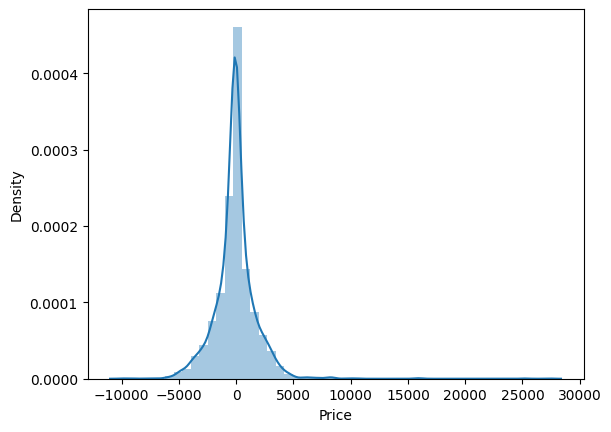

In [132]:
sns.distplot(target_test-prediction, bins=50)
plt.show()